# California Housing Price Model
## Objective
Predict median housing prices using an end-to-end ML pipeline in scikit-learn.'

1. Import Libraries
2. Load Data
3. Exploratory Data Analysis (EDA)
4. Preprocessing
5. Modeling
6. Evaluation
7. Conclusions

## 1. Import initial libraries
## 2. Load Data and Train/Test Split

In [1]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

## Pull in Data
data = fetch_california_housing(as_frame=True)
df = data.frame
print(df.head())

## Split features and target
# 1. Define target
target_col = "MedHouseVal"

# 2. Separate features and target
x = df.drop(columns=[target_col])
y = df[target_col]

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


## 4. Preprocessing by assign correct column types and then transforming them

In [2]:
import pandas as pd
import numpy as np

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Core EDA function to classify feature types
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def auto_eda(df, numeric_threshold=10, text_char_threshold=50):
    """
    Automatically produces a detailed summary of all feature types.

    Parameters:
        numeric_threshold: threshold below which numeric columns are treated as categorical
        text_char_threshold: average length threshold for identifying free-text columns
        
    Returns:
        - feature_summary: dataframe containing metadata per column
        - feature_groups: dict mapping feature_type -> list of columns
    """

    summary = []

    for col in df.columns:
        dtype = df[col].dtype
        nunique = df[col].nunique(dropna=True)
        missing = df[col].isna().mean()

        # Default
        feature_type = "unknown"

        # Boolean
        if dtype == "bool":
            feature_type = "boolean"

        # Datetime
        elif np.issubdtype(dtype, np.datetime64):
            feature_type = "datetime"

        # Object (string-like)
        elif dtype == object:
            avg_len = df[col].astype(str).str.len().mean()
            if avg_len >= text_char_threshold:
                feature_type = "text"
            else:
                feature_type = "categorical"

        # Numeric
        elif np.issubdtype(dtype, np.number):
            # low cardinality numeric = categorical-like
            if nunique < numeric_threshold:
                feature_type = "numeric_low_cardinality"
            else:
                # detect id-like
                if nunique == df.shape[0]:
                    feature_type = "id_like"
                else:
                    feature_type = "numeric"

        # High cardinal categorical
        if feature_type == "categorical" and nunique > 50:
            feature_type = "categorical_high_cardinality"

        summary.append({
            "column": col,
            "dtype": str(dtype),
            "feature_type": feature_type,
            "nunique": nunique,
            "missing_pct": round(missing * 100, 2),
        })

    feature_summary = pd.DataFrame(summary)
    feature_groups = feature_summary.groupby("feature_type")["column"].apply(list).to_dict()

    return feature_summary, feature_groups

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Expanded datetime features transformers
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
from sklearn.preprocessing import FunctionTransformer

def extract_calendar_features(df):
    return pd.DataFrame({
        col + "_year": df[col].dt.year,
        col + "_month": df[col].dt.month,
        col + "_day": df[col].dt.day,
        col + "_weekday": df[col].dt.weekday
    } for col in df.columns).reset_index(drop=True)


def extract_cyclic_features(df):
    out = pd.DataFrame(index=df.index)
    for col in df.columns:
        month = df[col].dt.month
        dow = df[col].dt.weekday

        out[f"{col}_month_sin"] = np.sin(2*np.pi*month/12)
        out[f"{col}_month_cos"] = np.cos(2*np.pi*month/12)
        out[f"{col}_dow_sin"] = np.sin(2*np.pi*dow/7)
        out[f"{col}_dow_cos"] = np.cos(2*np.pi*dow/7)
    return out


def extract_fourier_features(df, K=3):
    out = pd.DataFrame(index=df.index)
    for col in df.columns:
        for cyc, period in {
            "month": 12,
            "dow": 7,
            "hour": 24
        }.items():
            values = getattr(df[col].dt, cyc)
            for k in range(1, K+1):
                out[f"{col}_{cyc}_sin_{k}"] = np.sin(2*np.pi*k*values/period)
                out[f"{col}_{cyc}_cos_{k}"] = np.cos(2*np.pi*k*values/period)
    return out

##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Apply actual preprocessing transformers of features. Choose datetime preprocessing method here.
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import numpy as np

def build_preprocessor(df, feature_groups, datetime_mode="calendar", fourier_k=3):
    """
    Build a preprocessing pipeline based on auto-detected feature types.

    Parameters:
        datetime_mode : str in {"none", "calendar", "cyclic", "fourier"}
        fourier_k : number of Fourier pairs to compute per datetime component

    Returns:
        sklearn ColumnTransformer
    """

    transformers = []

    # =============================
    #  Numeric
    # =============================
    if "numeric" in feature_groups:
        transformers.append(
            (
                "numeric",
                Pipeline([
                    ("scaler", StandardScaler())
                    # WHY → numeric features vary widely in scale.
                    # Scaling improves convergence for linear models,
                    # makes distance-based models meaningful,
                    # and prevents large-scale features from dominating.
                ]),
                feature_groups["numeric"]
            )
        )

    # =============================
    #  Numeric (low cardinality)
    # =============================
    if "numeric_low_cardinality" in feature_groups:
        transformers.append(
            (
                "num_low_card",
                Pipeline([
                    ("onehot", OneHotEncoder(handle_unknown="ignore"))
                    # WHY → integers with few unique values behave like categories.
                    # Using one-hot preserves discrete boundaries and avoids misleading
                    # distances caused by scaling continuous values.
                ]),
                feature_groups["numeric_low_cardinality"]
            )
        )

    # =============================
    #  Categorical
    # =============================
    if "categorical" in feature_groups:
        transformers.append(
            (
                "categorical",
                Pipeline([
                    ("onehot", OneHotEncoder(handle_unknown="ignore"))
                    # WHY → categorical values must be encoded numerically.
                    # One-hot prevents ordinal assumptions that integer encoding introduces.
                ]),
                feature_groups["categorical"]
            )
        )

    # =============================
    #  High-cardinality categorical
    # =============================
    if "categorical_high_cardinality" in feature_groups:
        transformers.append(
            (
                "cat_high_card",
                Pipeline([
                    ("onehot", OneHotEncoder(handle_unknown="ignore"))
                    # WHY → high-cardinality features explode dimensionality.
                    # One-hot is still the safest option, but in production:
                    # - hashing
                    # - target encoding
                    # may be better.
                ]),
                feature_groups["categorical_high_cardinality"]
            )
        )

    # =============================
    #  Boolean
    # =============================
    if "boolean" in feature_groups:
        transformers.append(
            (
                "boolean",
                OneHotEncoder(drop="if_binary")
                # WHY → booleans behave like binary categories.
                # One-hot makes them explicitly 0/1 and avoids treating False < True
                # as a meaningful ordinal relationship.
                ,
                feature_groups["boolean"]
            )
        )

    # =============================
    #  Datetime (multiple modes)
    # =============================
    if "datetime" in feature_groups:

        def calendar_features(x):
            s = x.iloc[:, 0]
            return pd.DataFrame({
                "year": s.dt.year,
                "month": s.dt.month,
                "day": s.dt.day,
                "weekday": s.dt.weekday
            })
            # WHY → Calendar decomposition extracts interpretable components.
            # Good for linear models and trees.  
        
        def cyclic_features(x):
            s = x.iloc[:, 0]
            df = pd.DataFrame({
                "month_sin": np.sin(2 * np.pi * s.dt.month / 12),
                "month_cos": np.cos(2 * np.pi * s.dt.month / 12),
                "weekday_sin": np.sin(2 * np.pi * s.dt.weekday / 7),
                "weekday_cos": np.cos(2 * np.pi * s.dt.weekday / 7),
            })
            return df
            # WHY → Cyclic encoding preserves wrap-around structure (Dec→Jan).
            # Great for linear models and models sensitive to numeric distances.
        
        def fourier_features(x):
            s = x.iloc[:, 0]
            out = {}
            for col_name, period in [("month", 12), ("weekday", 7)]:
                vals = getattr(s.dt, col_name)
                for k in range(1, fourier_k + 1):
                    out[f"{col_name}_sin_{k}"] = np.sin(2 * np.pi * k * vals / period)
                    out[f"{col_name}_cos_{k}"] = np.cos(2 * np.pi * k * vals / period)
            return pd.DataFrame(out)
            # WHY → Fourier captures multiple frequencies (seasonality, patterns).
            # Best for time-series or models where smooth periodicity matters.

        # Select mode
        if datetime_mode == "none":
            # Datetime left out entirely
            pass

        elif datetime_mode == "calendar":
            transformers.append(
                (
                    "datetime_calendar",
                    Pipeline([
                        ("calendar", FunctionTransformer(calendar_features)),
                        ("onehot", OneHotEncoder(handle_unknown="ignore"))
                        # WHY → Calendar parts are categorical.
                        # One-hot prevents wrong ordinal relationships (e.g., month 2 < month 11)
                    ]),
                    feature_groups["datetime"]
                )
            )

        elif datetime_mode == "cyclic":
            transformers.append(
                (
                    "datetime_cyclic",
                    Pipeline([
                        ("cyc", FunctionTransformer(cyclic_features))
                        # WHY → Cyclic encodes periodicity in a way linear models understand.
                        # No one-hot needed; values already continuous & normalized.
                    ]),
                    feature_groups["datetime"]
                )
            )

        elif datetime_mode == "fourier":
            transformers.append(
                (
                    "datetime_fourier",
                    Pipeline([
                        ("fourier", FunctionTransformer(fourier_features))
                        # WHY → Fourier allows richer periodic patterns than simple sin/cos.
                        # Better for capturing multi-frequency seasonality.
                    ]),
                    feature_groups["datetime"]
                )
            )

        else:
            raise ValueError("datetime_mode must be one of: none, calendar, cyclic, fourier")

    # =============================
    #  Text
    # =============================
    if "text" in feature_groups:
        transformers.append(
            (
                "text",
                TfidfVectorizer()
                # WHY → Converts raw text into weighted token counts.
                # TF-IDF reduces the impact of common words and highlights meaningful terms.
            ),
            feature_groups["text"]
        )

    # id_like → implicitly dropped

    return ColumnTransformer(transformers, remainder="drop")




## Apply Preprocessing

In [3]:
# 1. Run auto-EDA
# feature_summary → pandas DataFrame with column metadata
# feature_groups → dict mapping feature_type -> list of columns
feature_summary, feature_groups = auto_eda(x)

# Look at the detailed summary
print(feature_summary.head())
# Look at the grouped features by type
print(feature_groups)

# 2. Build the preprocessor
preprocessor = build_preprocessor(x, feature_groups, datetime_mode="calendar")

       column    dtype feature_type  nunique  missing_pct
0      MedInc  float64      numeric    12928          0.0
1    HouseAge  float64      numeric       52          0.0
2    AveRooms  float64      numeric    19392          0.0
3   AveBedrms  float64      numeric    14233          0.0
4  Population  float64      numeric     3888          0.0
{'numeric': ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']}


## Fit a Model

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import numpy as np
import joblib

def run_ml_pipeline_general(
    df, 
    target_col, 
    preprocessor, 
    model, 
    problem_type="regression", 
    test_size=0.2, 
    random_state=42,
    save_pipeline=True
):
    """
    Build, train, and evaluate a generalized ML pipeline.

    Parameters:
        df : pandas DataFrame
        target_col : str, name of target column
        preprocessor : sklearn ColumnTransformer, pre-built
        model : sklearn estimator (regressor or classifier)
        problem_type : str, "regression" or "classification"
        test_size : float, test split fraction
        random_state : int
        save_pipeline : bool, whether to save the trained pipeline

    Returns:
        pipeline : trained sklearn Pipeline
        X_train, X_test, y_train, y_test
    """

    # -------------------------
    # 1. Split data
    # -------------------------
    X = df.drop(columns=[target_col])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # -------------------------
    # 2. Build pipeline
    # -------------------------
    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("model", model)
    ])

    # -------------------------
    # 3. Fit pipeline
    # -------------------------
    pipeline.fit(X_train, y_train)

    # -------------------------
    # 4. Evaluate
    # -------------------------
    y_pred = pipeline.predict(X_test)

    if problem_type == "regression":
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"R²: {r2:.3f}, RMSE: {rmse:.3f}")
    elif problem_type == "classification":
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {acc:.3f}")
    else:
        raise ValueError("problem_type must be 'regression' or 'classification'")

    # -------------------------
    # 5. Save pipeline
    # -------------------------
    #if save_pipeline:
    #    joblib.dump(pipeline, f"{target_col}_pipeline.pkl")

    return pipeline, X_train, X_test, y_train, y_test


In [5]:
from sklearn.ensemble import RandomForestRegressor

pipeline, x_train, x_test, y_train, y_test = run_ml_pipeline_general(
    df,
    target_col="MedHouseVal",
    preprocessor=preprocessor,
    model=RandomForestRegressor(n_estimators=200, random_state=42),
    problem_type="regression"
)


R²: 0.806, RMSE: 0.504


## Further results analysis

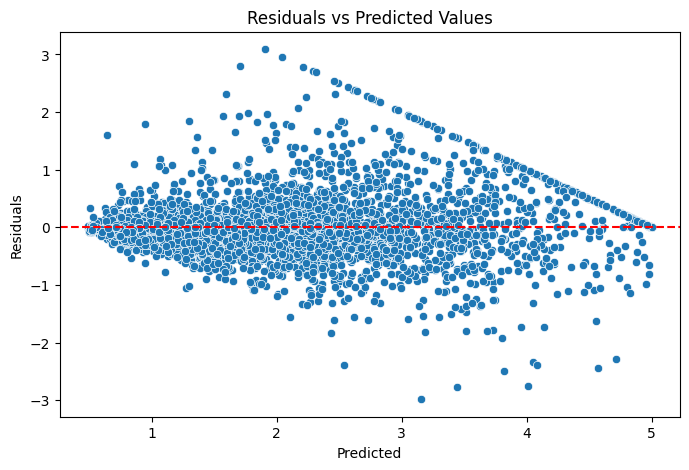

               feature  importance
0      numeric__MedInc    0.525886
5    numeric__AveOccup    0.138055
6    numeric__Latitude    0.088647
7   numeric__Longitude    0.088307
1    numeric__HouseAge    0.054355
2    numeric__AveRooms    0.044449
4  numeric__Population    0.030693
3   numeric__AveBedrms    0.029608


: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred = pipeline.predict(x_test)
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

# Feature importances (RandomForest)
importances = pipeline.named_steps['model'].feature_importances_
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()
feat_imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values(by="importance", ascending=False)
print(feat_imp_df.head(10))